# Week 2: Predicting time series

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

2024-07-11 12:51:50.271230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 12:51:50.271411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 12:51:50.478326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Generating the data

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

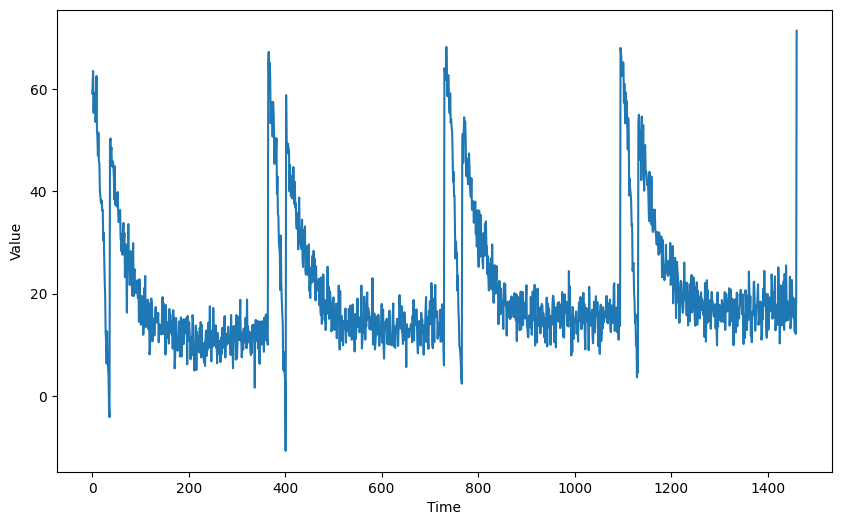

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Splitting the data

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

## Processing the data

In [7]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    
    ### START CODE HERE
    
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series) # tf.data.Dataset.range(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Split it into the features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)
    
    ### END CODE HERE
    
    return dataset

In [8]:
# Test your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


## Defining the model architecture

In [9]:
def create_model(window_size=G.WINDOW_SIZE):

    ### START CODE HERE

    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ]) 

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9))
    
    ### END CODE HERE

    return model

In [10]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train it
model.fit(dataset, epochs=100)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 585.2763
Epoch 2/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 651.4988

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 553.1072 
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 522.2084 
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 527.1825 
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 470.0333 
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 483.0772 
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 476.4918 
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 451.6400 
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 389.5585 
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 440.2845 
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 386.7720 
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 432.1768 
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 352.1390 
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 396.7196 
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 359.2796 
Epoch 16/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluating the forecast

In [16]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.MeanSquaredError()
    mse.update_state(true_series, forecast)
    mse_result = mse.result().numpy()
    
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)
    mae_result = mae.result().numpy()
    ### END CODE HERE

    return mse_result, mae_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

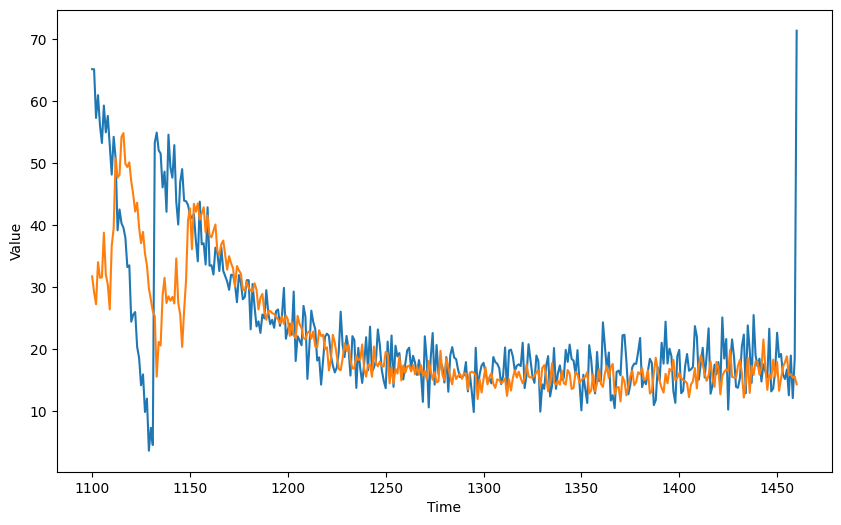

In [17]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results


# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

In [18]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 88.67, mae: 5.69 for forecast


In [19]:
# Save your model in HDF5 format
model.save('my_model.h5')